<a href="https://www.kaggle.com/code/maimunulkjisan/bengtrans-hatedetect-using-bert?scriptVersionId=172607336" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bengali Hateful Speech Detection after translate to English With Classic ML and Bert Models
### Description

In this notebook, I aim to explore various methods for detecting hateful speech within the dataset.
1. Translate Bangla hate speech into English 
1. TF-IDF with Linear Regression model
2. Bert model with native Pytorch 
3. Fine-tuning a model with the Trainer API

<a ></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;"> Translation (Bengali to English) 💎</p>


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bengali-hate-speech-dataset/Bengali hate speech .csv


In [2]:
!pip download transformers==4.25.1
!pip install /kaggle/working/transformers-4.25.1-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 819.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.

In [3]:
import json
import torch
import pandas as pd
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from tqdm.auto import tqdm
%env TOKENIZERS_PARALLELISM=true
device = torch.device('cuda')

2024-04-18 05:19:05.380806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 05:19:05.380912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 05:19:05.638851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


env: TOKENIZERS_PARALLELISM=true


In [4]:
class CFG:
    INPUT = '/kaggle/input/bengali-hate-speech-dataset'
    TRANS_MODEL = 'facebook/nllb-200-distilled-600M'

In [5]:
df = pd.read_csv(f'{CFG.INPUT}/Bengali hate speech .csv')
display(df)

,sentence,hate,category
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports
...,...,...,...
29995,আমার মনে হচ্ছে মেনে নেয়া উচিত,0,"Meme, TikTok and others"
29996,আমি ধন্যবাদ জানাই আইনপসাসনকে,0,"Meme, TikTok and others"
29997,কাসমির কাসমিরই নিজশ্যই সাদিন হওয়ার দরকার,0,"Meme, TikTok and others"
29998,কলমি পিলিজ আপু মনি অনেক কিওট লাগছে,0,"Meme, TikTok and others"


In [6]:
#By Stpete Ishii https://www.kaggle.com/code/stpeteishii/bengali-to-english-translation

model = AutoModelForSeq2SeqLM.from_pretrained(CFG.TRANS_MODEL)
torch.save(model.state_dict(), './nllb-200-distilled-600M.pth')
model.eval()
model.to(device)
tokenizer = AutoTokenizer.from_pretrained(CFG.TRANS_MODEL)
tokenizer.save_pretrained('./tokenizer/')

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/sentencepiece.bpe.model',
 './tokenizer/added_tokens.json',
 './tokenizer/tokenizer.json')

In [7]:
#Stpete Ishii https://www.kaggle.com/code/stpeteishii/bengali-to-english-translation

def translate_by_nllb(text, tokenizer, model, device):
    inputs = tokenizer(text, return_tensors="pt")    
    for k, v in inputs.items():
        inputs[k] = v.to(device)
    translated_tokens = model.generate(
        **inputs, forced_bos_token_id=tokenizer.lang_code_to_id["eng_Latn"], max_length=64
    )
    return tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]

In [8]:
for i, row in tqdm(df.iterrows(), total=len(df)):
    df.loc[i, 'eng'] = translate_by_nllb(row['sentence'], tokenizer, model, device)

display(df)

  0%|          | 0/30000 [00:00<?, ?it/s]

,sentence,hate,category,eng
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,I have to go to the hospital.
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,I need to take the papans to the hospital.
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,The son of Lord Jillur Rahman Sir would be so ...
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,It looks like a reading to see a bitch
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,You're a piece of shit. You're gonna play it b...
...,...,...,...,...
29995,আমার মনে হচ্ছে মেনে নেয়া উচিত,0,"Meme, TikTok and others",I think I should accept it.
29996,আমি ধন্যবাদ জানাই আইনপসাসনকে,0,"Meme, TikTok and others",I thank the legislature.
29997,কাসমির কাসমিরই নিজশ্যই সাদিন হওয়ার দরকার,0,"Meme, TikTok and others",Kashmir Kashmir is supposed to be its own day
29998,কলমি পিলিজ আপু মনি অনেক কিওট লাগছে,0,"Meme, TikTok and others","I'm calling you, please. I need a lot of money."


In [9]:
# Assuming 'eng' column has been populated with translations

# Save the DataFrame to a CSV file
translated_csv_path = "/kaggle/working/translated_data.csv"
df.to_csv(translated_csv_path, index=False)

# Print the path to the saved CSV file
print("Translated data saved to:", translated_csv_path)


Translated data saved to: /kaggle/working/translated_data.csv


<a ></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;"> Data Cleaning 💎</p>


In [10]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
from pathlib import Path

from collections import Counter
import random
import operator
from tqdm import tqdm
import time

from wordcloud import WordCloud
from string import punctuation
import nltk
import subprocess

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertModel, BertTokenizer

from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import evaluate

%matplotlib inline

In [12]:
data_full=df

In [13]:
data_full.drop(columns=['category'],inplace=True, axis=1)


In [14]:
data_full.rename(columns={'hate':'Label','eng':'Content'},inplace=True)


In [15]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data_full['Label'] = encoder.fit_transform(data_full['Label'])


In [16]:
data_full = data_full.drop_duplicates(keep='first')
data_full.head()

,sentence,Label,Content
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,I have to go to the hospital.
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,I need to take the papans to the hospital.
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,The son of Lord Jillur Rahman Sir would be so ...
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,It looks like a reading to see a bitch
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,You're a piece of shit. You're gonna play it b...


In [17]:
data_full.groupby('Label').count()

,sentence,Content
Label,,
0,19905,19905
1,9959,9959


In [18]:
#The dataset is quite big so we take just 4000 examples of each class
df1 = data_full.query('Label == 0')
df2 = data_full.query('Label == 1')
data = pd.concat([df1, df2], ignore_index=True)

data.shape

(29864, 3)

<a ></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;"> Data Exploration 💎</p>


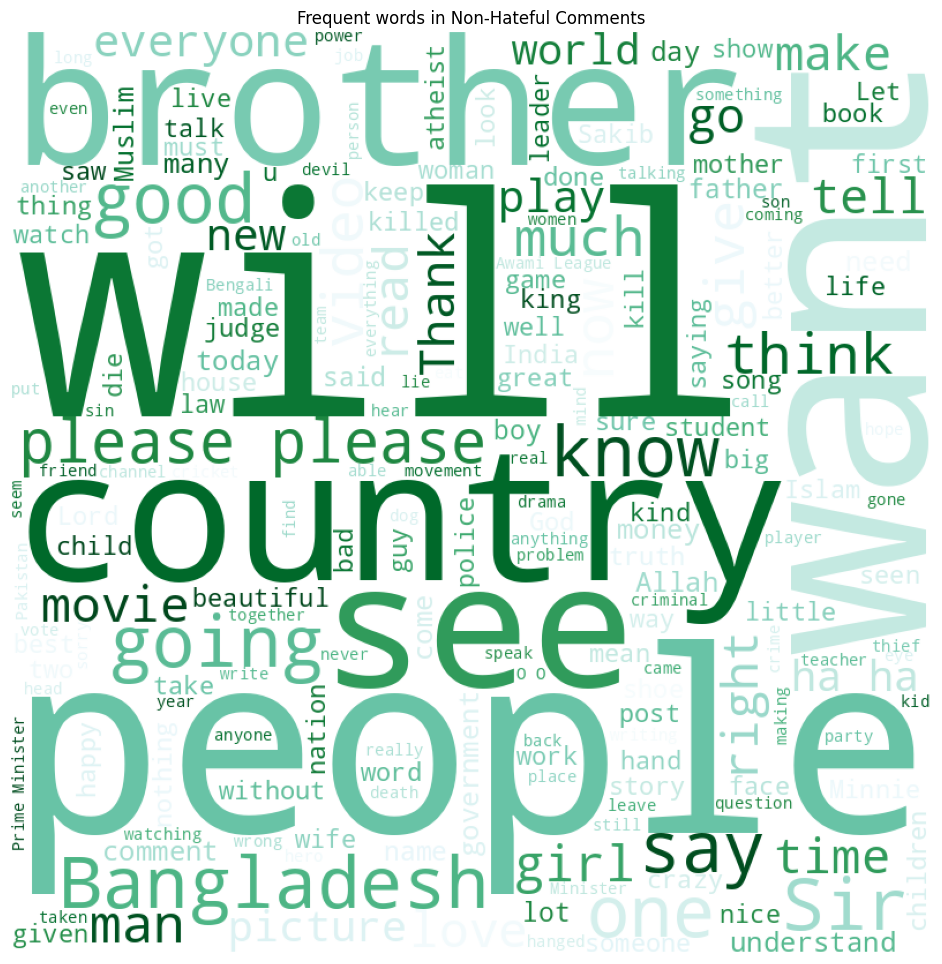

In [19]:
combined_title = ' '.join(df1['Content'])

wordcloud_img = WordCloud(width = 800, height = 800,
                            background_color ='white', colormap = 'BuGn',
                            min_font_size = 10).generate(combined_title)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_img)
plt.axis('off')
plt.title('Frequent words in Non-Hateful Comments')
plt.tight_layout(pad=2)
plt.show()

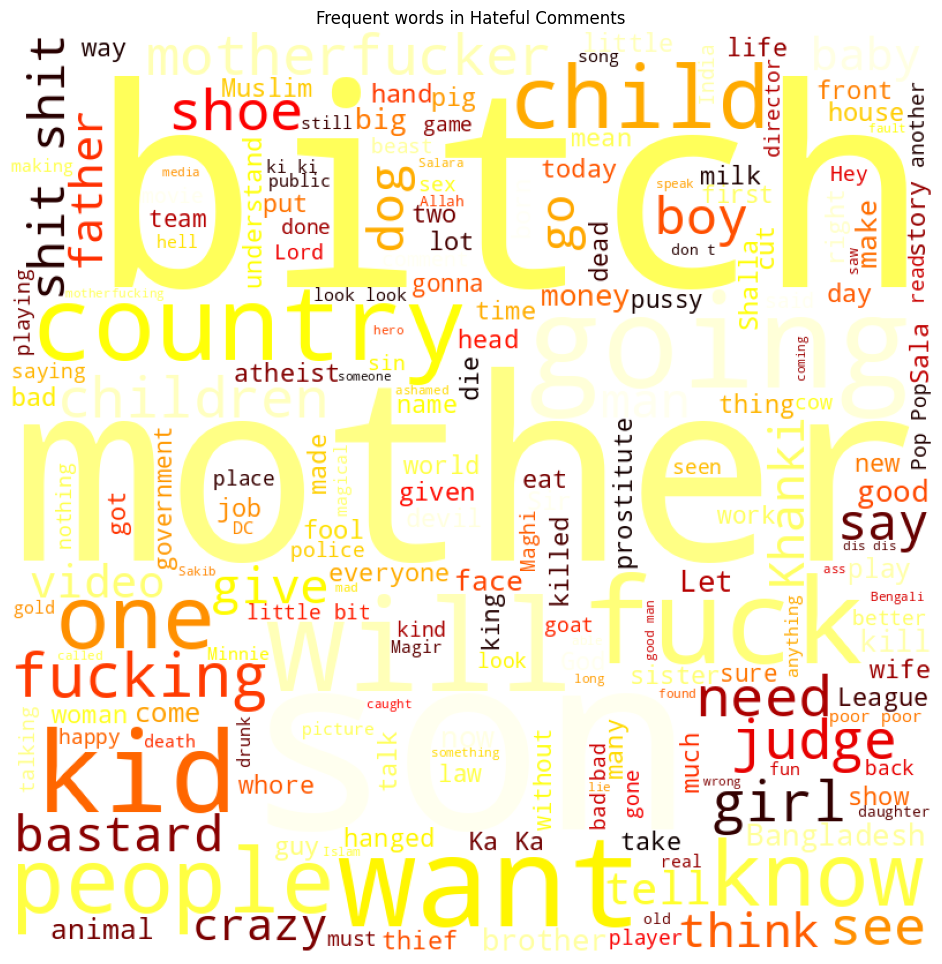

In [20]:
combined_title = ' '.join(df2['Content'])

wordcloud_img = WordCloud(width = 800, height = 800,
                            background_color ='white', colormap = 'hot_r',
                            min_font_size = 10).generate(combined_title)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_img)
plt.axis('off')
plt.title('Frequent words in Hateful Comments')
plt.tight_layout(pad=2)
plt.show()

<a ></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;"> Pre-processing 💎</p>


# TF-IDF with Linear Regression model  
  
This approach can be considered as baseline.  
Firstly, we need clean and prepare text: clean, remove stopwords, apply lemmatization OR stemming. By default I choose stemming.  
Then convert text to TF-IDF vector and use it as a feature for simple classification model LogisticRegression

In [21]:
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [22]:
data_tfidf = data.copy()

In [23]:
stopwords_l = stopwords.words('english')

punctuation = re.compile("[" + re.escape(string.punctuation) + "]")

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english') #Snowball stemmer initialised

def text_cleaning(text, mode="stemming"):
    res = []
    text_clean = re.sub(punctuation,'',text)
    tokens = word_tokenize(text_clean)
    
    for token in tokens:
        if token.lower() not in stopwords_l:
            if mode == "stemming":
                prepared_word = stemmer.stem(token)
            else:
                prepared_word = lemmatizer.lemmatize(token)            
            res.append(prepared_word)
    return ' '.join(res)

In [24]:
data_tfidf['cleaned_text'] = data_tfidf['Content'].apply(text_cleaning)

In [25]:
data_tfidf.sample(5)

,sentence,Label,Content,cleaned_text
10712,ফরিদপুরের একজনের খোজ জানি আমার আব্বু আম্মু কে ...,0,I know my father and mother are boss in Faridpur,know father mother boss faridpur
17384,আমরা মুসলমান আমাদের বাবরি মসজিদ চাই,0,We Muslims want our Babri Masjid,muslim want babri masjid
14639,প্রিয় লেখকের কলামের পাঠক প্রতিক্রিয়া একটু পড়িও...,0,Dear author of the column readers reply a litt...,dear author column reader repli littl readyo l...
12929,শিক্ষিক আওয়ামিলীগের দালাল,0,The Ministry of Education,ministri educ
16467,আপনার কথায় একমত স্যার!,0,"I agree with you, sir.",agre sir


In [26]:
train, test = train_test_split(data_tfidf, test_size=0.2, stratify=data_tfidf['Label'], random_state=42)

X_train = train['cleaned_text']
y_train = train['Label']

X_test = test['cleaned_text']
y_test = test['Label']

In [27]:
# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X_train_vect = tfidf_vectorizer.fit_transform(X_train)

X_test_vect = tfidf_vectorizer.transform(X_test)

In [28]:
linear_clf = LogisticRegression()

# train the model with training data processed using TF-IDF
linear_clf.fit(X_train_vect, y_train)

LogisticRegression()

In [29]:
y_pred_tf_idf = linear_clf.predict(X_test_vect)


report = classification_report(y_test, y_pred_tf_idf)
print(report)

display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_test, y_pred_tf_idf)[:, 0], 
              "Predicted: Hateful": confusion_matrix(y_test, y_pred_tf_idf)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      3981
           1       0.78      0.52      0.63      1992

    accuracy                           0.79      5973
   macro avg       0.79      0.72      0.74      5973
weighted avg       0.79      0.79      0.78      5973



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,3687,294
Actual: Hateful,950,1042


<a ></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;"> Bert model with native Pytorch  💎</p>

 
  
Now I want to train Bert model with classification head with native Pytorch.   


In [30]:
data = data_tfidf

In [31]:
data.head()

,sentence,Label,Content,cleaned_text
0,ভারতের ষড়যন্ত্রের শিকার সাকিববাংলাদেশ ক্রিকেট ...,0,I hate the plot to destroy Bangladesh cricket ...,hate plot destroy bangladesh cricket icc randi...
1,টিম ডংসো হইছে সাল থেকেওয়ার্ল্ড কাপে তার প্রমান...,0,Tim Dungso has been since the World Cup his pr...,tim dungso sinc world cup proofr like year oka...
2,এক এক যুগে বাংলাদেশ একেকটা হিরোকে ধ্বংস করছে,0,In an era Bangladesh is destroying every singl...,era bangladesh destroy everi singl hero
3,নটির পোলা পাপন সব তোর খেলা,0,Not a child of yours,child
4,বাংলাদেশের মানুষ সবাই গর্জে ওঠো পাপনের বিরুদ্ধ...,0,Everyone in Bangladesh is against the guilt of...,everyon bangladesh guilt sin destroy banglades...


In [32]:
train, validation = train_test_split(data, test_size=0.2, stratify=data_tfidf['Label'], random_state=42)

In [33]:
# Define Dataset 
class HateSpeechDataset(Dataset):
    
    def __init__(self, data):
        
        # Initialize BERT tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')        
        self.data = data
       
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data.iloc[idx]

        text = example["cleaned_text"]
        label = example["Label"]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"], ##.unsqueeze(0).int(),
            "label": label,
        }
    

In [34]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')      

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [35]:
dataset_train = HateSpeechDataset(train)
dataset_val = HateSpeechDataset(validation)

#data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create DataLoader
batch_size = 128
dataloader_train = DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: {
        "input_ids": torch.stack([item["input_ids"] for item in x]),
        "attention_mask": torch.stack([item["attention_mask"] for item in x]),
        "labels": torch.tensor([item["label"] for item in x])
    },
    #collate_fn=data_collator,
    pin_memory=True,
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: {
        "input_ids": torch.stack([item["input_ids"] for item in x]),
        "attention_mask": torch.stack([item["attention_mask"] for item in x]),
        "labels": torch.tensor([item["label"] for item in x])
    },
    #collate_fn=data_collator,
    pin_memory=True,
)

In [36]:
# Define BERT classifier
class BERTClassifier(nn.Module):
    
    def __init__(self):
        
        # Specify network layers
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        
        self.linear = nn.Linear(self.bert.config.hidden_size, 1)
        
        # Define dropout
        self.dropout = nn.Dropout(0.1)
        
        # Freeze BERT layers
        for n, p in self.bert.named_parameters():
            p.requires_grad = False
            
    def forward(self, text, masks):
        #output_bert = self.bert(text, attention_mask=masks).last_hidden_state.mean(axis=1)
        #print(output_bert.last_hidden_state)
        #print(self.bert.config.hidden_size)
        
        output_bert = self.bert(text, attention_mask=masks).last_hidden_state
        output_bert = self.avg_pool(output_bert.transpose(1, 2)).squeeze(-1)
        
        return self.linear(self.dropout(output_bert))

In [37]:
model = BERTClassifier()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
# Define optimiser, objective function and epochs
optimizer = optim.Adam(model.parameters(), lr=0.001) #optim.AdamW(model.parameters(), lr=5e-5) #
criterion = nn.BCEWithLogitsLoss()
epochs = 30

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<a ></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;"> Train with native Pytorch  💎</p>


In [40]:
model.to(device)

val_losses = []
train_losses = []

# Train model
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    model.train()
    print(f"Start training epoch {epoch_i}...")
    total_train_loss = 0
    for i, batch in enumerate(tqdm(dataloader_train)):
    
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        label = batch['labels'].to(device) 

        output = model(input_ids, masks)
        loss = criterion(output.squeeze(), label.float())

        loss.backward()
        
        # Clip the norm of the gradients to 1.0 to prevent the "exploding gradients".
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_train_loss += loss.item()
        
    avg_train_loss = total_train_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)
    # ========================================
    #               Validation
    # ========================================
    
    model.eval()
    print("Start validation...")
    y_true_bert = list()
    y_pred_bert = list()
    
    total_eval_loss = 0.0
    with torch.no_grad():
        for batch in dataloader_val:
            input_ids = batch['input_ids'].to(device)
            masks = batch['attention_mask'].to(device)
            label = batch['labels'].to(device)
            
            output = model(input_ids, masks)
            max_output = (torch.sigmoid(output).cpu().numpy().reshape(-1)>= 0.5).astype(int)
            y_true_bert.extend(label.tolist())
            y_pred_bert.extend(max_output.tolist())
            
            loss_v = criterion(output.squeeze(), label.float())
            total_eval_loss += loss.item()
    avg_val_loss = total_eval_loss / len(dataloader_val)
    val_losses.append(avg_val_loss)
    
    print(f"Metrics after Epoch {epoch_i}")     
    print(f"Accuracy : {accuracy_score(y_true_bert, y_pred_bert)}")
    print(f"Presision: {np.round(precision_score(y_true_bert, y_pred_bert),3)}")
    print(f"Recall: {np.round(recall_score(y_true_bert, y_pred_bert),3)}") 
    print(f"F1: {np.round(f1_score(y_true_bert, y_pred_bert),3)}")
    print("   ")  

Start training epoch 0...


100%|██████████| 187/187 [01:18<00:00,  2.38it/s]

Start validation...


Metrics after Epoch 0
Accuracy : 0.7408337518834757
Presision: 0.721
Recall: 0.363
F1: 0.483
   
Start training epoch 1...


100%|██████████| 187/187 [01:17<00:00,  2.41it/s]

Start validation...


Metrics after Epoch 1
Accuracy : 0.7465260338188515
Presision: 0.699
Recall: 0.422
F1: 0.526
   
Start training epoch 2...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 2
Accuracy : 0.7483676544450025
Presision: 0.704
Recall: 0.423
F1: 0.529
   
Start training epoch 3...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 3
Accuracy : 0.7493721747865394
Presision: 0.725
Recall: 0.4
F1: 0.516
   
Start training epoch 4...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 4
Accuracy : 0.7500418550142307
Presision: 0.681
Recall: 0.471
F1: 0.557
   
Start training epoch 5...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 5
Accuracy : 0.7518834756403817
Presision: 0.714
Recall: 0.427
F1: 0.535
   
Start training epoch 6...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 6
Accuracy : 0.7513812154696132
Presision: 0.674
Recall: 0.494
F1: 0.57
   
Start training epoch 7...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 7
Accuracy : 0.7523857358111502
Presision: 0.702
Recall: 0.448
F1: 0.547
   
Start training epoch 8...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 8
Accuracy : 0.7557341369496066
Presision: 0.712
Recall: 0.449
F1: 0.551
   
Start training epoch 9...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 9
Accuracy : 0.7547296166080697
Presision: 0.698
Recall: 0.467
F1: 0.559
   
Start training epoch 10...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 10
Accuracy : 0.7550644567219152
Presision: 0.711
Recall: 0.447
F1: 0.549
   
Start training epoch 11...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 11
Accuracy : 0.7532228360957642
Presision: 0.692
Recall: 0.468
F1: 0.558
   
Start training epoch 12...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 12
Accuracy : 0.7498744349573079
Presision: 0.67
Recall: 0.493
F1: 0.568
   
Start training epoch 13...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 13
Accuracy : 0.7570734974049891
Presision: 0.72
Recall: 0.444
F1: 0.55
   
Start training epoch 14...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 14
Accuracy : 0.7555667168926837
Presision: 0.725
Recall: 0.43
F1: 0.54
   
Start training epoch 15...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 15
Accuracy : 0.7569060773480663
Presision: 0.714
Recall: 0.453
F1: 0.554
   
Start training epoch 16...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 16
Accuracy : 0.7569060773480663
Presision: 0.702
Recall: 0.471
F1: 0.564
   
Start training epoch 17...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 17
Accuracy : 0.7465260338188515
Presision: 0.641
Recall: 0.545
F1: 0.589
   
Start training epoch 18...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 18
Accuracy : 0.7569060773480663
Presision: 0.714
Recall: 0.452
F1: 0.554
   
Start training epoch 19...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 19
Accuracy : 0.7574083375188347
Presision: 0.706
Recall: 0.468
F1: 0.563
   
Start training epoch 20...


100%|██████████| 187/187 [01:17<00:00,  2.41it/s]

Start validation...


Metrics after Epoch 20
Accuracy : 0.7552318767788381
Presision: 0.723
Recall: 0.431
F1: 0.54
   
Start training epoch 21...


100%|██████████| 187/187 [01:17<00:00,  2.41it/s]

Start validation...


Metrics after Epoch 21
Accuracy : 0.7570734974049891
Presision: 0.713
Recall: 0.454
F1: 0.555
   
Start training epoch 22...


100%|██████████| 187/187 [01:17<00:00,  2.41it/s]

Start validation...


Metrics after Epoch 22
Accuracy : 0.7550644567219152
Presision: 0.703
Recall: 0.46
F1: 0.556
   
Start training epoch 23...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 23
Accuracy : 0.7575757575757576
Presision: 0.721
Recall: 0.446
F1: 0.551
   
Start training epoch 24...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 24
Accuracy : 0.7557341369496066
Presision: 0.679
Recall: 0.508
F1: 0.581
   
Start training epoch 25...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 25
Accuracy : 0.7570734974049891
Presision: 0.714
Recall: 0.453
F1: 0.554
   
Start training epoch 26...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 26
Accuracy : 0.7567386572911434
Presision: 0.707
Recall: 0.462
F1: 0.559
   
Start training epoch 27...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 27
Accuracy : 0.7559015570065294
Presision: 0.687
Recall: 0.492
F1: 0.574
   
Start training epoch 28...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 28
Accuracy : 0.7550644567219152
Presision: 0.693
Recall: 0.477
F1: 0.565
   
Start training epoch 29...


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]

Start validation...


Metrics after Epoch 29
Accuracy : 0.7520508956973045
Presision: 0.678
Recall: 0.489
F1: 0.568
   


In [41]:
print('Test accuracy: {:.2f}'.format(accuracy_score(y_true_bert, y_pred_bert)))
print('\nClassification report: \n', classification_report(y_true_bert, y_pred_bert))
print('\nConfusion matrix: \n')
display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_true_bert, y_pred_bert)[:, 0], 
              "Predicted: Hateful": confusion_matrix(y_true_bert, y_pred_bert)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

Test accuracy: 0.75

Classification report: 
               precision    recall  f1-score   support

           0       0.78      0.88      0.83      3981
           1       0.68      0.49      0.57      1992

    accuracy                           0.75      5973
   macro avg       0.73      0.69      0.70      5973
weighted avg       0.74      0.75      0.74      5973


Confusion matrix: 



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,3517,464
Actual: Hateful,1017,975


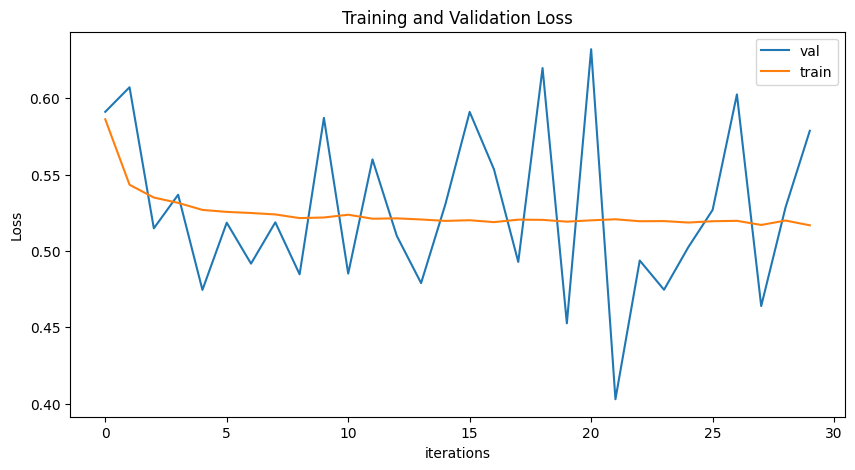

In [42]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

<a ></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;"> Fine-tuning a model with the Trainer API  💎</p>
  
In this section, along with Trainer API, I apply the AutoModelForSequenceClassification. This model automatically includes a classification head, so there's no need for any additional configuration. Train params are default


In [43]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
training_args = TrainingArguments(output_dir="test_trainer", report_to="none")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [44]:
metric_acc = evaluate.load("accuracy")
metric_prec = evaluate.load("precision")
metric_recall = evaluate.load("recall")

In [45]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=predictions, references=labels)["accuracy"]
    prec = metric_prec.compute(predictions=predictions, references=labels)["precision"]
    rec = metric_recall.compute(predictions=predictions, references=labels)["recall"]
    
    return {"accuracy": acc,"precision": prec, "recall": rec}

In [46]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')    
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [47]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    compute_metrics=compute_metrics,
    data_collator = data_collator
    
)

In [48]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 23891
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4482
  Number of trainable parameters = 109483778
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.549000
1000,0.488000
1500,0.471100
2000,0.413300
2500,0.416700
3000,0.403800
3500,0.332500
4000,0.324400


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved

TrainOutput(global_step=4482, training_loss=0.4123295141830342, metrics={'train_runtime': 890.9166, 'train_samples_per_second': 80.449, 'train_steps_per_second': 5.031, 'total_flos': 2357244833852160.0, 'train_loss': 0.4123295141830342, 'epoch': 3.0})

In [49]:
model.eval()
print("Start validation...")
y_true_auto_bert  = list()
y_pred_auto_bert = list()

total_eval_loss = 0.0
with torch.no_grad():
    for batch in dataloader_val:
        input_ids = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        label = batch['labels'].to(device)

        output = model(input_ids, masks)
        max_output = np.argmax(output.logits.cpu().numpy(), axis=-1)
        y_true_auto_bert.extend(label.tolist())
        y_pred_auto_bert.extend(max_output.tolist())


print(f"Accuracy : {accuracy_score(y_true_auto_bert, y_pred_auto_bert)}")
print(f"Presision: {np.round(precision_score(y_true_auto_bert, y_pred_auto_bert),3)}")
print(f"Recall: {np.round(recall_score(y_true_auto_bert, y_pred_auto_bert),3)}") 
print(f"F1: {np.round(f1_score(y_true_auto_bert, y_pred_auto_bert),3)}")
print("   ")  


print('Test accuracy: {:.2f}'.format(accuracy_score(y_true_auto_bert, y_pred_auto_bert)))
print('\nClassification report: \n', classification_report(y_true_auto_bert, y_pred_auto_bert))
print('\nConfusion matrix: \n')
display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_true_auto_bert, y_pred_auto_bert)[:, 0], 
              "Predicted: Hateful": confusion_matrix(y_true_auto_bert, y_pred_auto_bert)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

Start validation...
Accuracy : 0.8039511133433785
Presision: 0.719
Recall: 0.677
F1: 0.697
   
Test accuracy: 0.80

Classification report: 
               precision    recall  f1-score   support

           0       0.84      0.87      0.86      3981
           1       0.72      0.68      0.70      1992

    accuracy                           0.80      5973
   macro avg       0.78      0.77      0.78      5973
weighted avg       0.80      0.80      0.80      5973


Confusion matrix: 



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,3453,528
Actual: Hateful,643,1349
